In [2]:
%matplotlib widget
# Add the directory containing the package to sys.path
import sys, os
package_dir = os.path.abspath("C:/Users/froll/Documents/Labo/Projets/Outils/swd")
if package_dir not in sys.path:
    sys.path.insert(0, package_dir)
    
from swd import spherical_processing as sp
from swd import geotools as geo
from swd import plots as splots
import swd as swd
import importlib

importlib.reload(swd.plots)
import numpy as np
from numpy import pi, cos, sin
import matplotlib.pyplot as plt

import warnings
#from utils_DirViolins import *
warnings.filterwarnings("ignore")
from tqdm import tqdm
np.set_printoptions(precision=2, suppress=True)
# Enable LaTeX rendering
plt.rc('text', usetex=True)
# Improve resolution
plt.rcParams['figure.dpi'] = 150
plt.rcParams['savefig.dpi'] = 300

In [3]:
#Vitesse du son au moment de la mesure, dependant de la temperature:
Tc = 21.5 
C = np.sqrt( 1.4 * 287 *(Tc + 273) )
Path = './'
NbMems = 256
NbViolTot = 6
NbViol = 6
OSH = 7
Dyn = 36

NbSH = (OSH+1)**2
NumViolon = np.load('./../results/NumViolon.npz')['NumViolon']

# Chargement des coordonnées des sources et des microphones 
# obtenues par RMDU à partir des TOAs figurant dans HybridTOAs.npy

XYZViolins = np.load('./../results/XYZViolinsAligned.npy')

NbMics = 256
NbSrcs = XYZViolins.shape[0] - NbMics

# Dans le tableau des coordonnées, les NbSrcs premier triplets correspondent aux Sources
# La dernière source correspond au sommet du chevalet , point d'impact du marteau
# Ce point d'impact est pris comme centre acoustique pour tous les calculs suivant et défini comme origine de l'espace de coordonnées

XYZHammerImpact = XYZViolins[NbSrcs-1]
XYZ = XYZViolins-XYZHammerImpact
XYZs = XYZ[:NbSrcs-1]
XYZm = XYZ[NbSrcs:]
XYZHammerImpact = XYZ[NbSrcs-1]

In [4]:
# Violin positioning
# Define rotation functions locally to avoid dependency issues
def x_rotate_coordinates(coords, a):
    R_x = np.array([
        [1, 0, 0],
        [0, np.cos(a), -np.sin(a)],
        [0, np.sin(a), np.cos(a)]
    ])
    return np.dot(R_x, coords)

def y_rotate_coordinates(coords, a):
    R_y = np.array([
        [np.cos(a), 0, np.sin(a)],
        [0, 1, 0],
        [-np.sin(a), 0, np.cos(a)]
    ])
    return np.dot(R_y, coords)

def z_rotate_coordinates(coords, a):
    R_z = np.array([
        [np.cos(a), -np.sin(a), 0],
        [np.sin(a), np.cos(a), 0],
        [0, 0, 1]
    ])
    return np.dot(R_z, coords)

import trimesh
#Dimensions hors tout du violon Stradivarius Willemotte 1732, d'apres les mesures de Sacconi:
Wv = 206.5e-3  # Convert mm to meters
Lv = 485.7e-3
Hv = 94.7e-3

mesh = trimesh.load('../src/Meshes/violin.ply')  # Can also load .obj or .mtl files
# Extract vertices and faces
vertices = mesh.vertices
vertices -= vertices.mean(axis=0)
rx = 90 * pi/180 
ry = 0 * pi/180 
rz = -90 * pi/180
vertices = x_rotate_coordinates(vertices.T,    rx).T
vertices = y_rotate_coordinates(vertices.T,    ry).T
vertices = z_rotate_coordinates(vertices.T,    rz).T

Dims0 = vertices.max(axis=0) - vertices.min(axis=0)
DimsV = np.array([Hv, Wv, Lv])
Scale = DimsV / Dims0
vertices *= Scale
SommetChevalet = vertices[np.abs(vertices[:,0]).argmax()]
# On recentre le sommet du chevalet à l'origine de l'espace de coordonnées
vertices -= SommetChevalet
faces = mesh.faces

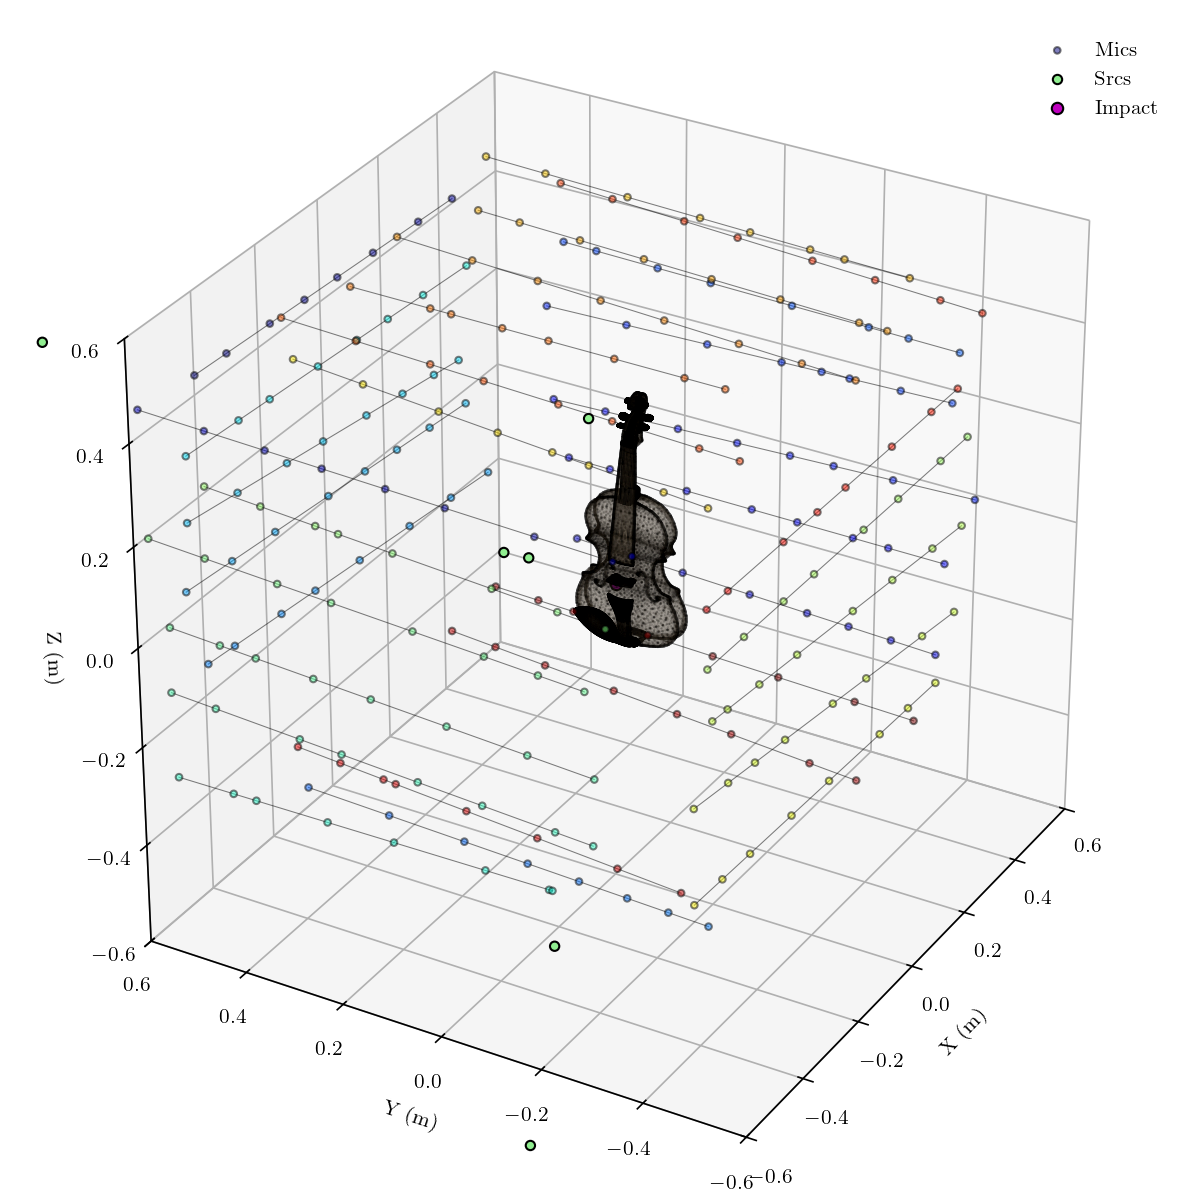

In [5]:
fig = plt.figure(1, figsize=(8, 8))
ax2 = fig.add_subplot(111, projection='3d')
ax2.scatter(*XYZm.T, c =np.arange(NbMics), marker='o',edgecolor='k', s=10, cmap='jet',alpha = 0.5, label = 'Mics')
ax2.scatter(*XYZs.T, marker='o',facecolor ='lightgreen',edgecolor='k', s=20, alpha=1, label = 'Srcs')
ax2.scatter(*XYZHammerImpact.T, marker = 'o', facecolor ='m', edgecolor='k', s=30 ,label='Impact')

for i in range(0, NbMics, 8):
    ax2.plot(XYZm[i:i+8,0], XYZm[i:i+8,1], XYZm[i:i+8,2], color='k', linewidth=0.5, alpha=0.5)

#ax2.set_label([str(i) for i in NumF])
ax2.legend()  
L = 0.6
ax2.set_xlim([-L,L])
ax2.set_ylim([-L,L])
ax2.set_zlim([-L,L])
ax2.set_aspect('equal')

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

light_brown = (0.87, 0.72, 0.53)  # RGB values for light brown
mesh_collection = Poly3DCollection(vertices[faces], alpha=0.1, edgecolor='k', facecolor=light_brown)
ax2.add_collection3d(mesh_collection)
# Set labels
ax2.set_xlabel('X (m)')
ax2.set_ylabel('Y (m)')
ax2.set_zlabel('Z (m)')

ax2.view_init(elev=30, azim=210, roll=0) 
ax2.dist = 0.1  
ax2.legend(loc='upper right', fontsize=10, frameon=False)
plt.tight_layout()
# Show the plot
plt.show()

In [5]:

# 3D Visualization using pythreejs
try:
    from pythreejs import *
    from IPython.display import display
except ImportError:
    print("pythreejs is not installed. Please install it using: %pip install pythreejs")

if 'pythreejs' in sys.modules:
    # Helper to create BufferAttribute
    def make_buffer_attr(array):
        return BufferAttribute(array=array.astype(np.float32, copy=False))

    scene_children = []

    # Microphones (Mics) - Blue Spheres
    mics_geo = SphereGeometry(radius=0.0075, widthSegments=8, heightSegments=8)
    mics_mat = MeshLambertMaterial(color='blue')
    for pos in XYZm:
        scene_children.append(Mesh(geometry=mics_geo, material=mics_mat, position=pos.tolist()))

    # Sources (Srcs) - Green Spheres
    srcs_geo = SphereGeometry(radius=0.01, widthSegments=8, heightSegments=8)
    srcs_mat = MeshLambertMaterial(color='lightgreen')
    for pos in XYZs:
        scene_children.append(Mesh(geometry=srcs_geo, material=srcs_mat, position=pos.tolist()))

    # Impact - Magenta Sphere
    impact_geo = SphereGeometry(radius=0.015, widthSegments=16, heightSegments=16)
    impact_mat = MeshLambertMaterial(color='magenta')
    scene_children.append(Mesh(geometry=impact_geo, material=impact_mat, position=XYZHammerImpact.tolist()))

    # Lines connecting mics in chunks of 8
    line_positions = []
    for i in range(0, NbMics, 8):
        # Create segments (0,1), (1,2), ..., (6,7)
        for j in range(7):
            if i + j + 1 < NbMics:
                line_positions.append(XYZm[i+j])
                line_positions.append(XYZm[i+j+1])
    
    line_positions = np.array(line_positions)
    if len(line_positions) > 0:
        lines_geo = BufferGeometry(attributes={'position': make_buffer_attr(line_positions)})
        lines_mat = LineBasicMaterial(color='black', linewidth=1, transparent=True, opacity=0.5)
        lines = LineSegments(geometry=lines_geo, material=lines_mat)
        scene_children.append(lines)

    # Violin Mesh
    if 'vertices' in locals() and 'faces' in locals():
        # Faces must be flattened for index
        faces_flat = faces.flatten().astype(np.uint32)
        
        mesh_geo = BufferGeometry(
            attributes={
                'position': make_buffer_attr(vertices),
                'index': BufferAttribute(array=faces_flat, itemSize=1)
            }
        )
        
        # Simple light brown material
        # Note: For proper lighting, normals are needed. 
        # We can try to rely on pythreejs/threejs computing them or use basic material if it looks bad.
        # MeshLambertMaterial requires normals. MeshBasicMaterial does not but has no shading.
        # Let's try to add normals if we can, or use double side.
        
        # Adding a helper to compute normals (requires knowing structure, usually handled by three.js helper but pythreejs is low level)
        # We'll use MeshLambert and hope for the best, or create normals via trimesh if possible.
        # vertices are already modified, normals need to be recomputed.
        
        # Re-computing normals using trimesh relative to the transformed vertices
        # We can create a temporary trimesh object to compute vertex normals
        try:
            tm_mesh = trimesh.Trimesh(vertices=vertices, faces=faces)
            tm_mesh.fix_normals()
            normals = tm_mesh.vertex_normals
            mesh_geo.attributes['normal'] = make_buffer_attr(normals)
        except:
             pass 

        mesh_mat = MeshLambertMaterial(color='#DEB887', transparent=True, opacity=0.75, side='DoubleSide')
        violin_mesh = Mesh(geometry=mesh_geo, material=mesh_mat)
        scene_children.append(violin_mesh)

        # Add mesh edges (wireframe)
        wireframe_geo = WireframeGeometry(geometry=mesh_geo)
        wireframe_mat = LineBasicMaterial(color='black', linewidth=1, transparent=True, opacity=0.2)
        wireframe = LineSegments(geometry=wireframe_geo, material=wireframe_mat)
        scene_children.append(wireframe)

    # Scene
    scene = Scene(children=scene_children)

    # Lights
    key_light = DirectionalLight(color='white', position=[5, 5, 10], intensity=0.8)
    fill_light = DirectionalLight(color='white', position=[-5, 0, 5], intensity=0.5)
    amb_light = AmbientLight(color='#777777')
    scene.add([key_light, fill_light, amb_light])

    # Camera
    camera = PerspectiveCamera(position=[-1,1,1], up=[0, 0, 1], aspect=1.0, fov=50)
    camera.lookAt([0, 0, 0])

    # Controls
    controls = OrbitControls(controlling=camera)
    
    # Renderer with square aspect ratio (800x800)
    renderer = Renderer(camera=camera, scene=scene, controls=[controls], width=800, height=800)
    display(renderer)

Renderer(camera=PerspectiveCamera(position=(-1.0, 1.0, 1.0), projectionMatrix=(1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0…

In [6]:
Pm = np.load('./../results/ViolinsFRFsAndRIs.npz')['Hhm']
frq = np.load('./../results/ViolinsFRFsAndRIs.npz')['frq']

NbTh = 52   #Nombre de theta                                    
NbPh = 52   #Nombre de phi
frqMax = 12500
CyclicScale = 'icefire' #edge, icefire, phase, hsv
RealScale = 'seismic'
Magnitudescale = 'inferno'

## Process the Spherical Harmonics Spectra for each Violin

In [7]:
Rm = np.linalg.norm(XYZm,axis=1)
Rmin = np.min(Rm)

In [8]:

Band = (frq>0) & (frq<frqMax)
f = frq[Band]
Nbf = len(f)
kvect= 2*pi*f.T/C
Nang = 50
NbTh, NbPh = 2*Nang+2, 2*Nang+2
angles_look, weights = swd.geotools.create_equal_angle_grid(Nang)

In [9]:
ProcessCmn = False
O_SH_vect = sp.compute_N_SH_vect(f,N_SH_max = OSH,rmin = Rmin)
Ho2f = sp.compute_SphericalWavesbasis_origin_to_field(XYZm, kvect, OSH, SH_center = np.array([0,0,0], dtype = float))
NbDirs = angles_look.shape[0]

if ProcessCmn:
    Cmn = np.zeros((NbViol, NbSH, Nbf), dtype = np.complex128)    
    Diag = np.zeros((NbViol, NbDirs, Nbf), dtype = np.complex128)
    for v in tqdm(range(NbViol)):
        P  = Pm[v,Band,:].T
        Cmn[v,:,:] = sp.compute_SHcoefs(P,Ho2f,O_SH_vect, lambda_reg=1e-4)
        Diag[v,:,:] = sp.compute_Dinf_from_SH_coefs_at_origin(Cmn[v,:,:], angles_look, kvect)

    np.savez(f'./../results/Cmn.npz', Cmn = Cmn)
    np.savez(f'./../results/Diag.npz', Diag = Diag, angles_look = angles_look)
else:
    Cmn = np.load(f'./../results/Cmn.npz')['Cmn']
    Diag = np.load(f'./../results/Diag.npz')['Diag']

In [10]:
OSHSpec = []
no = 0
for o in range(OSH+1):
    sho = np.arange(2*o+1) + no
    no = sho[-1]+1
    OSHSpec.append(np.abs(np.sum(Cmn[:,sho,:], axis = 1))**2)
OSHSpec = np.rollaxis(np.array(OSHSpec),1,0)
OSHSpecN = OSHSpec/np.max(OSHSpec, axis = (1,2))[:,None,None]
OSHSpecdB = 10*np.log10(OSHSpec/np.max(OSHSpec))
OSHSpecdBmax = np.max(OSHSpecdB)

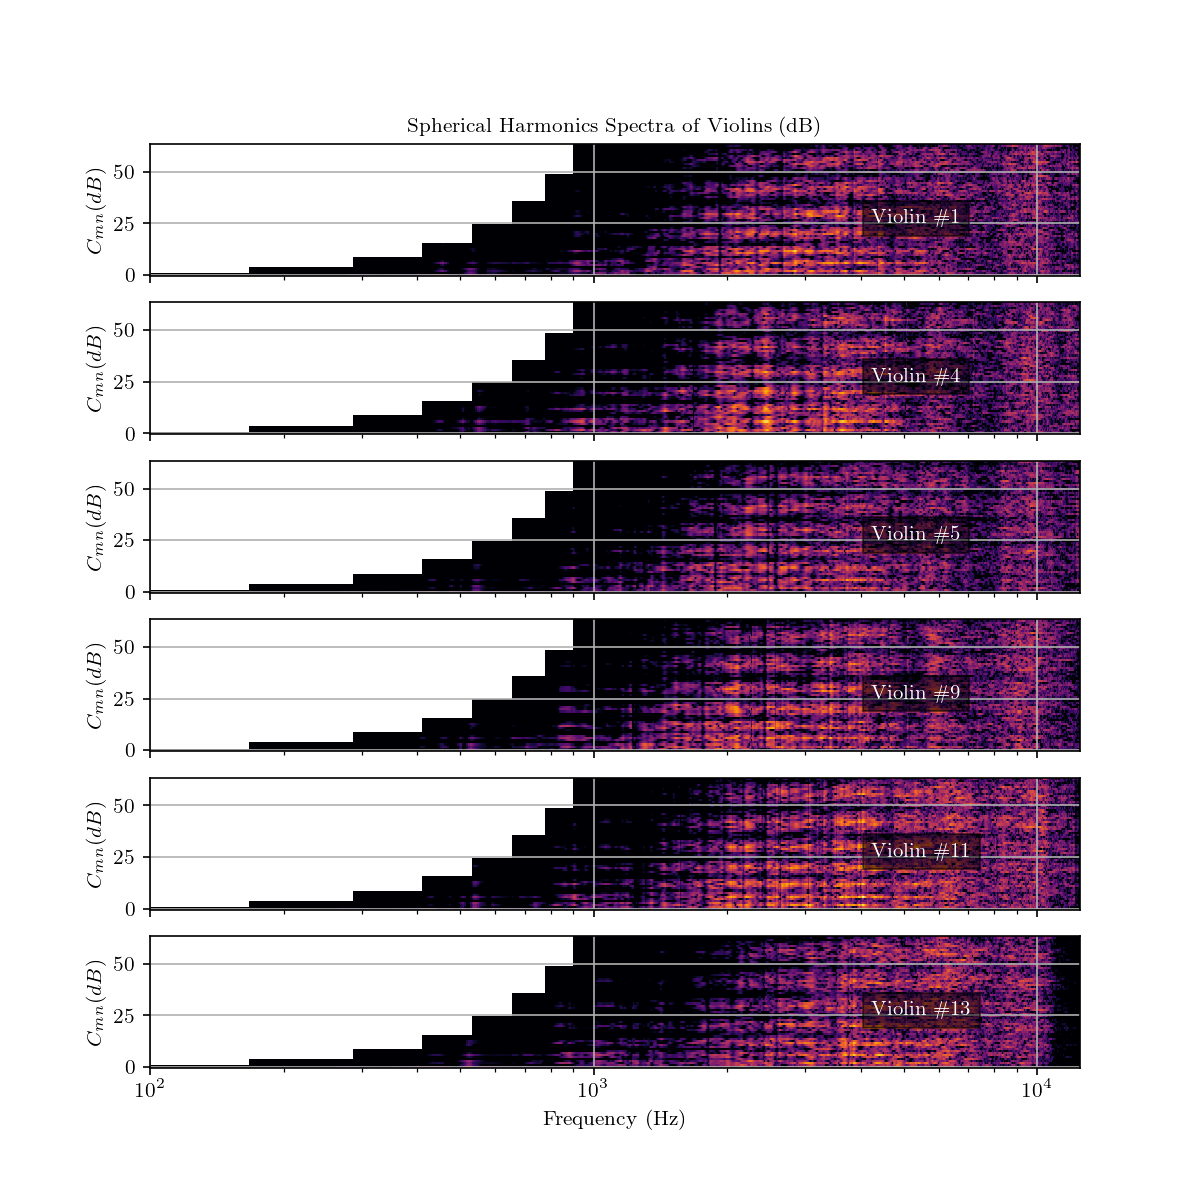

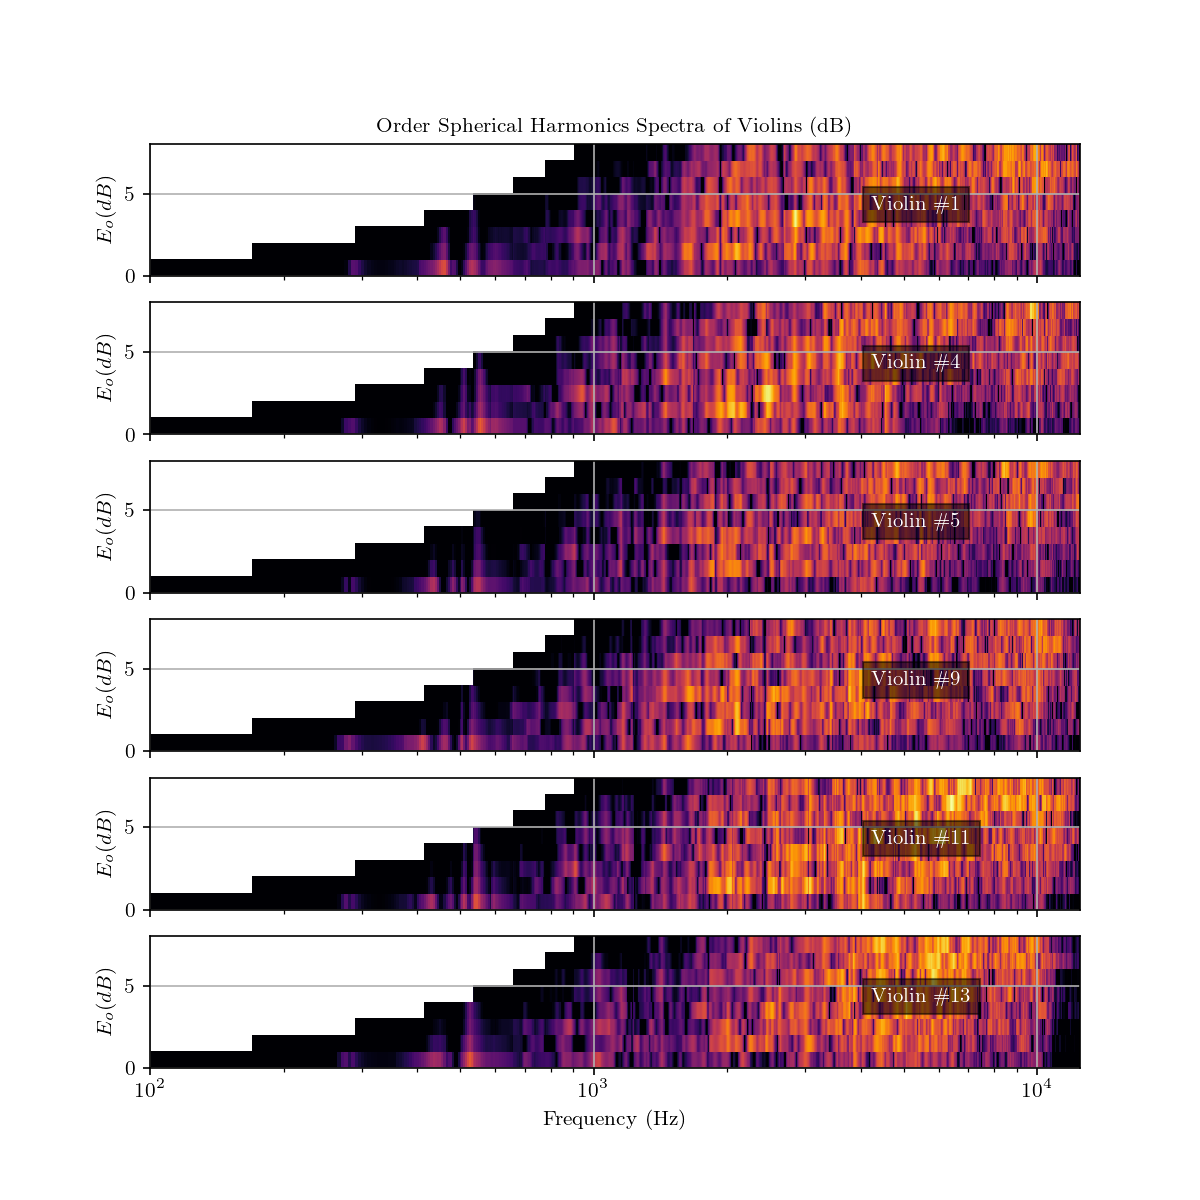

In [11]:
CmndB = 20*np.log10(np.abs(Cmn)/np.max(np.abs(Cmn)))
CmndBmax = np.max(CmndB)
NumViolon = [1, 4, 5, 9, 11, 13]  # Violons a analyser

figH,axH = plt.subplots(NbViol,1,figsize=(8,8))
figO,axO = plt.subplots(NbViol,1,figsize=(8,8))
for v in range(NbViol):
    c = axH[v].pcolor(f, np.arange(NbSH), CmndB[v,:,:], cmap=Magnitudescale, shading='nearest', vmin=CmndBmax-Dyn, vmax=CmndBmax)    
    axH[v].set_ylabel('$C_{mn} (dB)$')
    axH[v].grid()    
    axH[v].set_xscale('log')
    axH[v].set_xlim([100,frqMax])
    axH[v].annotate(f"Violin \#{NumViolon[v]:d}", xy=(3800, 25), xytext=(10, 0), textcoords='offset points', color='white',
            bbox=dict(facecolor='black', alpha=0.5))
    if v < NbViol-1:
        axH[v].set_xticklabels([])
    else:    
        axH[v].set_xlabel('Frequency (Hz)')     
    if not v : 
        axH[v].set_title('Spherical Harmonics Spectra of Violins (dB)')   
        #fig.colorbar(c, ax[v]) 
    X = np.arange(f[0],f[-1]+2*(f[1]-f[0]),f[1]-f[0])
    c = axO[v].pcolor(X, np.arange(OSH+2), OSHSpecdB[v,:,:], cmap=Magnitudescale, shading='flat', vmin=OSHSpecdBmax-Dyn, vmax=OSHSpecdBmax)    
    axO[v].set_ylabel('$E_o (dB)$')
    axO[v].grid()    
    axO[v].set_xscale('log')
    axO[v].set_xlim([100,frqMax])
    axO[v].annotate(f"Violin \#{NumViolon[v]:d}", xy=(3800, 4), xytext=(10, 0), textcoords='offset points', color='white',
            bbox=dict(facecolor='black', alpha=0.5))
    if v < NbViol-1:
        axO[v].set_xticklabels([])
    else:    
        axO[v].set_xlabel('Frequency (Hz)')     
    if not v : 
        axO[v].set_title('Order Spherical Harmonics Spectra of Violins (dB)')   
        #fig.colorbar(c, ax[v]) 
#fig.tight_layout()

Global max of |Diag| (99.9%): 1.2695e+03
Absolute max of |Diag|: 3.7803e+03


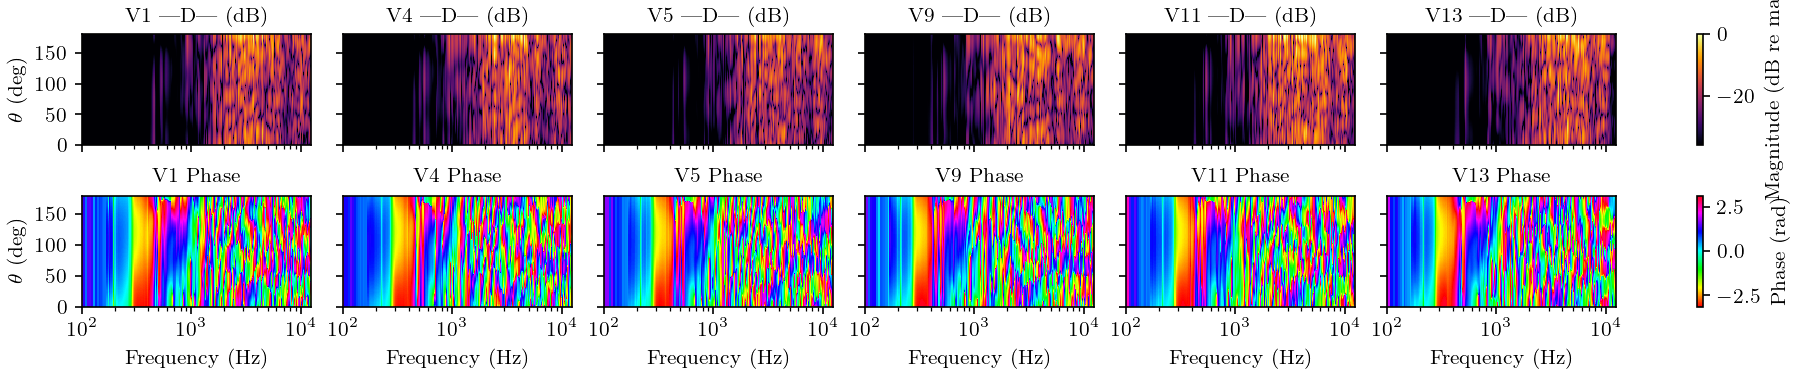

In [12]:
# Compute global maximum of the magnitude across all data (Violins, Angles, Frequencies)
# Use percentile to exclude outliers (e.g. 99.9%)
GlobMax = np.percentile(np.abs(Diag), 99.9)
print(f"Global max of |Diag| (99.9%): {GlobMax:.4e}")
print(f"Absolute max of |Diag|: {np.max(np.abs(Diag)):.4e}")

# Normalize and convert to dB
DiagdB = 20*np.log10(np.abs(Diag)/GlobMax)

# Clip outliers to 0 dB for visualization consistency
DiagdB[DiagdB > 0] = 0

# Build a first row of heatmaps where, for each violin, in the plane phi=0, 
# The magnitude of Diag in dB is plotted with the colormap inferno and a 30dB dynamics, theta versus frequency.
# A second row represents the phase of Diag using the hsv colormap.

# 1. Identify indices for phi ~ 0
phi_values = angles_look[:, 1]
# Find the phi value closest to 0
target_phi = 0
closest_phi = phi_values[np.argmin(np.abs(phi_values - target_phi))]
phi0_mask = np.isclose(phi_values, closest_phi)
phi0_indices = np.where(phi0_mask)[0]

# Sort indices by theta to ensure correct plotting order
sorted_idx_idx = np.argsort(angles_look[phi0_indices, 0])
phi0_indices = phi0_indices[sorted_idx_idx]
thetas_deg = angles_look[phi0_indices, 0] * 180 / np.pi

# 2. Plotting
fig, axes = plt.subplots(2, NbViol, figsize=(NbViol*2, 2.5), sharex=True, sharey=True, constrained_layout=True)

for v in range(NbViol):
    # Slice Diag for the specific violin and phi=0 plane
    # Diag shape: (NbViol, NbDirs, Nbf)
    DgdB_slice = DiagdB[v, phi0_indices, :]  # Shape: (NbTh_slice, Nbf)
    DgPh_slice = np.angle(Diag[v, phi0_indices, :])  # Shape: (NbTh_slice, Nbf)
    # --- Magnitude Plot (Row 0) ---
    
    ax_mag = axes[0, v]
    # Use pcolormesh. f is frequency, thetas_deg is theta. 
    # Transposing Mag_dB might depend on shape, but usually (Y, X) matches (thetas, f)
    
    pcm_mag = ax_mag.pcolormesh(f, thetas_deg, DgdB_slice, cmap='inferno', vmin=-Dyn, vmax=0, shading='auto')
    
    ax_mag.set_title(f'V{NumViolon[v]} |D| (dB)')
    ax_mag.set_xscale('log')
    ax_mag.set_xlim(100, frqMax)
    if v == 0:
        ax_mag.set_ylabel(f'$\\theta$ (deg)')

    # --- Phase Plot (Row 1) ---
    Phase = DgPh_slice
    
    ax_ph = axes[1, v]
    pcm_ph = ax_ph.pcolormesh(f, thetas_deg, Phase, cmap='hsv', vmin=-np.pi, vmax=np.pi, shading='auto')
    
    ax_ph.set_title(f'V{NumViolon[v]} Phase')
    ax_ph.set_xlabel('Frequency (Hz)')
    ax_ph.set_xscale('log')
    ax_ph.set_xlim(100, frqMax)
    if v == 0:
        ax_ph.set_ylabel(f'$\\theta$ (deg)')

fig.colorbar(pcm_mag, ax=axes[0, :], location='right', label='Magnitude (dB re max)')
fig.colorbar(pcm_ph, ax=axes[1, :], location='right', label='Phase (rad)')
plt.show()

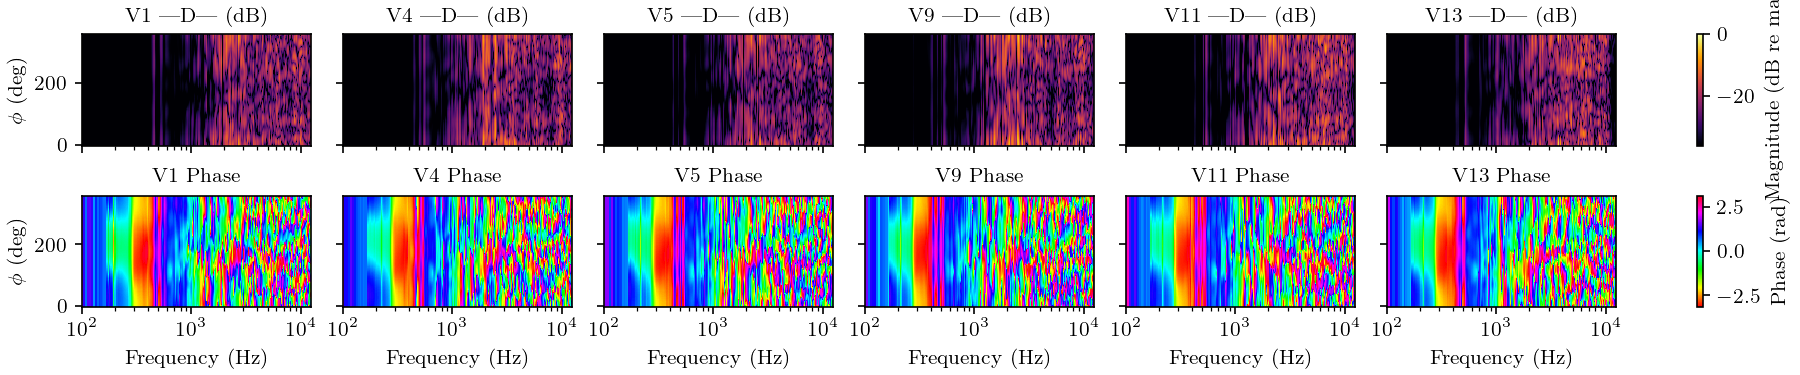

In [13]:
# Equivalent figure for theta = 90 deg (Equatorial plane), phi vs frequency
# Note: Theta=0 corresponds to the North Pole where variation with Phi is zero (singularity).
# We use Theta=pi/2 (90 degrees) to show the equatorial plane.

# 1. Identify indices for theta ~ 90 degrees
theta_values = angles_look[:, 0]
# Find the theta value closest to pi/2
target_theta = np.pi/2
closest_theta = theta_values[np.argmin(np.abs(theta_values - target_theta))]
theta0_mask = np.isclose(theta_values, closest_theta)
theta0_indices = np.where(theta0_mask)[0]

# Sort indices by phi to ensure correct plotting order
sorted_idx_idx = np.argsort(angles_look[theta0_indices, 1])
theta0_indices = theta0_indices[sorted_idx_idx]
phis_deg = angles_look[theta0_indices, 1] * 180 / np.pi

# 2. Plotting
fig, axes = plt.subplots(2, NbViol, figsize=(NbViol*2, 2.5), sharex=True, sharey=True, constrained_layout=True)

# Ensure GlobalMaxAbs is defined (if running this cell independently)
if 'GlobMax' not in locals():
    GlobMax = np.percentile(np.abs(Diag), 99.9)

for v in range(NbViol):
    # Slice Diag for the specific violin and theta=90 plane
    DgdB_slice = DiagdB[v, theta0_indices, :]  # Shape: (NbPh_slice, Nbf)
    DgPh_slice = np.angle(Diag[v, theta0_indices, :]) # Shape: (NbPh_slice, Nbf)
    # --- Magnitude Plot (Row 0) ---
    
    ax_mag = axes[0, v]
    pcm_mag = ax_mag.pcolormesh(f, phis_deg, DgdB_slice, cmap='inferno', vmin=-Dyn, vmax=0, shading='auto')
    
    ax_mag.set_title(f'V{NumViolon[v]} |D| (dB)')
    ax_mag.set_xscale('log')
    ax_mag.set_xlim(100, frqMax)
    if v == 0:
        ax_mag.set_ylabel(f'$\phi$ (deg)')

    # --- Phase Plot (Row 1) ---
    Phase = DgPh_slice
    
    ax_ph = axes[1, v]
    pcm_ph = ax_ph.pcolormesh(f, phis_deg, Phase, cmap='hsv', vmin=-np.pi, vmax=np.pi, shading='auto')
    
    ax_ph.set_title(f'V{NumViolon[v]} Phase')
    ax_ph.set_xlabel('Frequency (Hz)')
    ax_ph.set_xscale('log')
    ax_ph.set_xlim(100, frqMax)
    if v == 0:
        ax_ph.set_ylabel(f'$\phi$ (deg)')

fig.colorbar(pcm_mag, ax=axes[0, :], location='right', label='Magnitude (dB re max)')
fig.colorbar(pcm_ph, ax=axes[1, :], location='right', label='Phase (rad)')
plt.show()

Global Max Linear Amplitude (Octave): 2.5238e+04


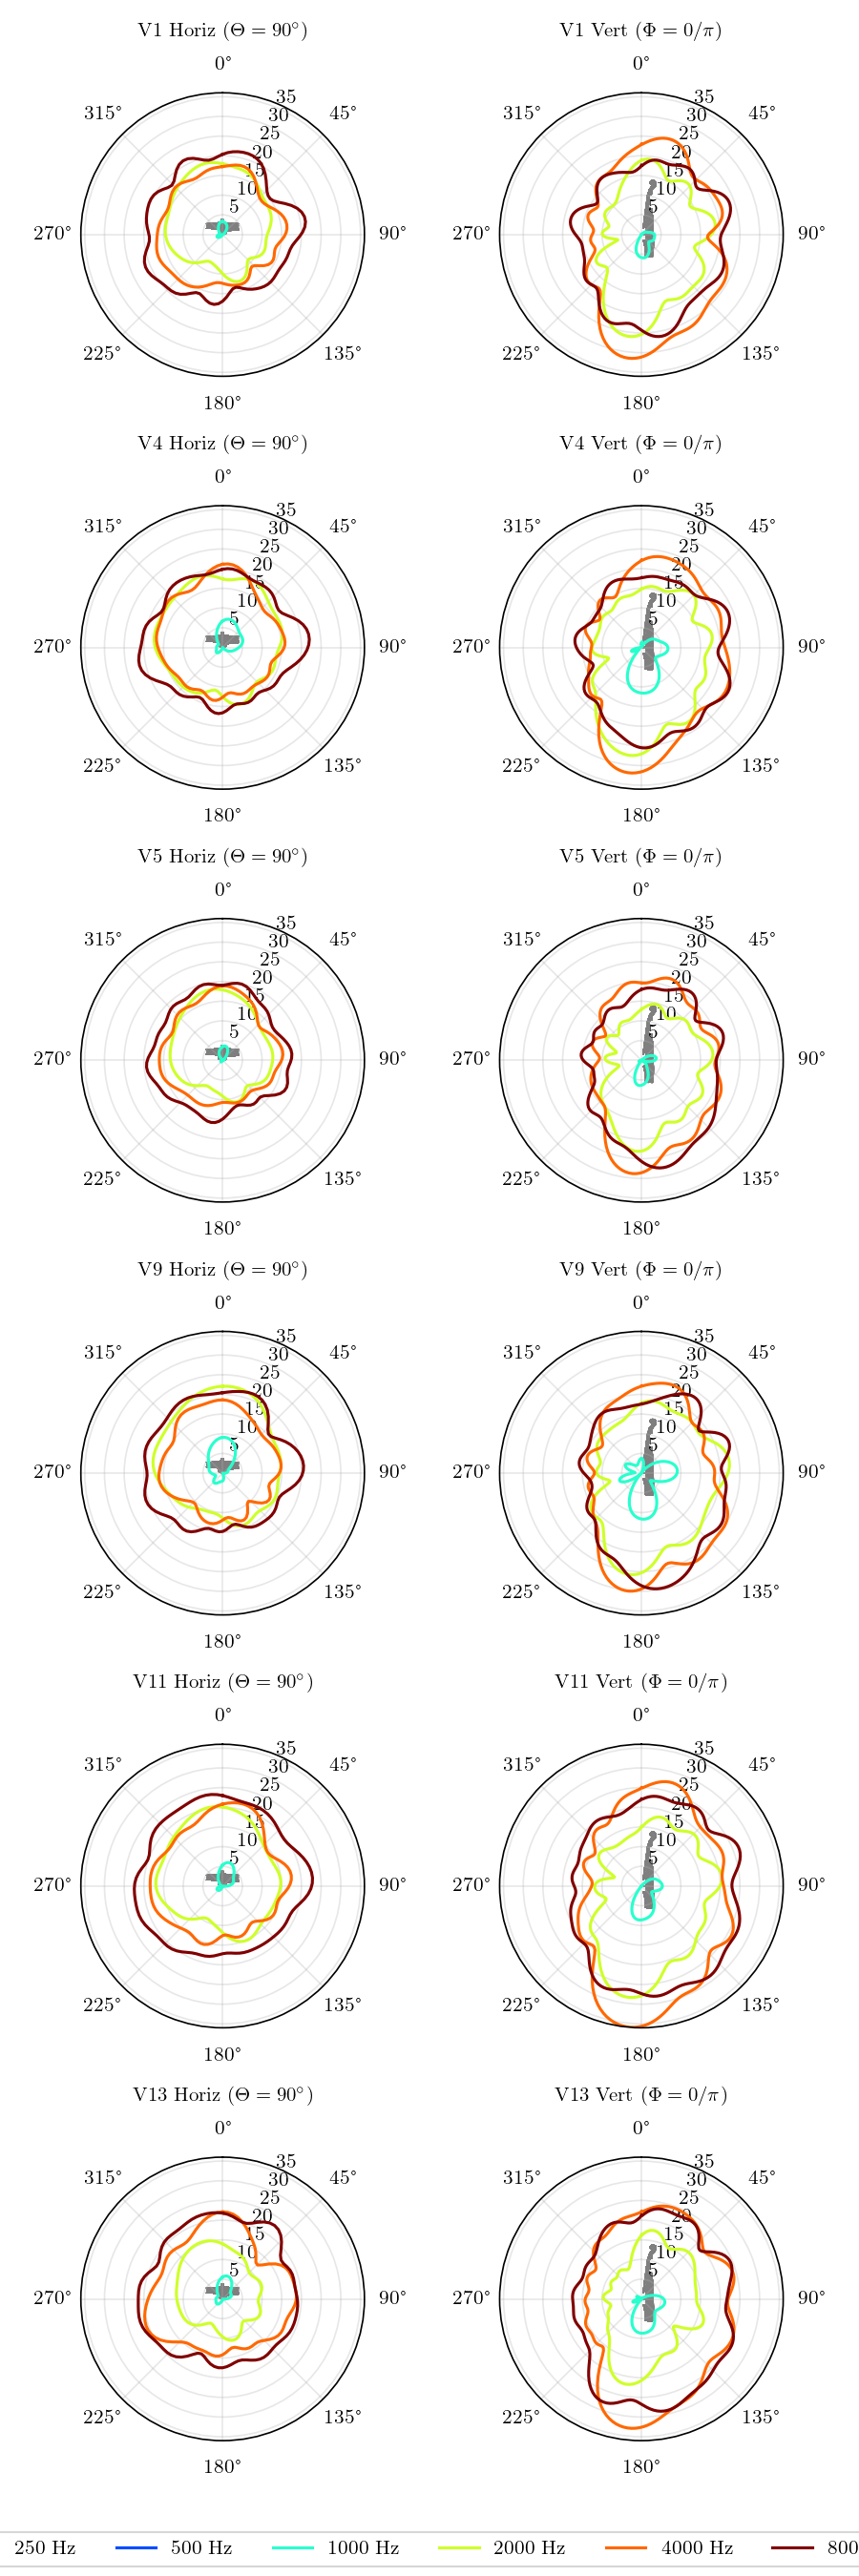

In [14]:
# Polar plots of DiagdB per Octave Band
# Row 1: Horizontal Plane (Theta = 90 deg)
# Row 2: Vertical Plane (Combined Phi=0 and Phi=pi)


# 1. Define Octave Bands
center_freqs = [250, 500, 1000, 2000, 4000, 8000] # Hz
band_indices = []
for fc in center_freqs:
    fmin = fc / np.sqrt(2)
    fmax = fc * np.sqrt(2)
    indices = np.where((f >= fmin) & (f <= fmax))[0]
    if len(indices) > 0:
        band_indices.append((fc, indices))

# 2. Calculate Linear Diag for all Bands first
NbBands_Oct = len(band_indices)
Diag_Band_Oct = np.zeros((NbViol, NbDirs, NbBands_Oct))

for i, (fc, idxs) in enumerate(band_indices):
    # Sum energy in band
    D_slice = Diag[:, :, :][:, :, idxs]
    # Sum of squares magnitude (Energy sum)
    Diag_Band_Oct[:, :, i] = np.sqrt(np.sum(np.abs(D_slice)**2, axis=2))

# 3. Global Max Reference
RefVal = np.max(Diag_Band_Oct)
print(f"Global Max Linear Amplitude (Octave): {RefVal:.4e}")

# Convert to dB
# Range: [max-Dyn, max] -> Shifted to [0, Dyn] for polar radius
Diag_Band_Oct_dB = 20 * np.log10(Diag_Band_Oct / RefVal + 1e-12)
Diag_Band_Oct_dB = np.maximum(Diag_Band_Oct_dB, -Dyn) + Dyn 

# 4. Prepare Indices for planes

# Plane Theta = 90 (Horizontal/Equatorial) -> Function of Phi
target_theta = np.pi/2
closest_theta = theta_values[np.argmin(np.abs(theta_values - target_theta))]
indices_th90 = np.where(np.isclose(theta_values, closest_theta))[0]
sort_th90 = np.argsort(angles_look[indices_th90, 1])
indices_th90 = indices_th90[sort_th90]
angles_ph_th90 = angles_look[indices_th90, 1] 

# Plane Phi = 0 (Vertical/Meridional Front)
target_phi = 0
closest_phi = phi_values[np.argmin(np.abs(phi_values - target_phi))]
indices_ph0 = np.where(np.isclose(phi_values, closest_phi))[0]
sort_ph0 = np.argsort(angles_look[indices_ph0, 0])
indices_ph0 = indices_ph0[sort_ph0]
angles_th_ph0 = angles_look[indices_ph0, 0] # 0 to pi

# Plane Phi = pi (Vertical/Meridional Back)
dist_pi = np.minimum(np.abs(phi_values - np.pi), np.abs(phi_values + np.pi))
indices_ph180 = np.where(np.isclose(dist_pi, np.min(dist_pi)))[0]
sort_ph180 = np.argsort(angles_look[indices_ph180, 0])
indices_ph180 = indices_ph180[sort_ph180]
angles_th_ph180 = angles_look[indices_ph180, 0] # 0 to pi usually

# 5. Create Figure
fig, axes = plt.subplots(NbViol,2, figsize=(6, NbViol*3), subplot_kw={'projection': 'polar'})

colors = plt.cm.jet(np.linspace(0, 1, len(band_indices)))

for v in range(NbViol):
    # --- Row 0: Horizontal Plane (Theta=90) ---
    ax_h = axes[v, 0]
    ax_h.set_title(f'V{NumViolon[v]} Horiz ($\Theta=90^\circ$)', fontsize=10, pad=10)
    
    for i, (fc, idxs) in enumerate(band_indices):
        # Extract pre-calculated dB values
        Mag_dB_plane = Diag_Band_Oct_dB[v, indices_th90, i]

        # Close the loop
        Mag_plot = np.append(Mag_dB_plane, Mag_dB_plane[0])
        Ang_plot = np.append(angles_ph_th90, angles_ph_th90[0] + 2*np.pi) 
        
        ax_h.plot(Ang_plot, Mag_plot, color=colors[i], linewidth=1.5, label=f'{fc} Hz' if v==0 else "")

    ax_h.set_theta_zero_location("N")
    ax_h.set_theta_direction(-1)
    ax_h.set_ylim(0, Dyn)
    ax_h.set_rticks(np.arange(5, Dyn+1, 5))
    ax_h.grid(True, alpha=0.3)

    scale_val = 1.0
    if 'vertices' in locals() and 'faces' in locals():
        r_xy = np.hypot(vertices[:,0], vertices[:,1])
        scale_val = 5.0 / (np.max(r_xy) + 1e-12)
        r_xy = r_xy * scale_val
        th_xy = np.arctan2(vertices[:,1], vertices[:,0])
        ax_h.triplot(th_xy, r_xy, triangles=faces, color='k', alpha=0.5, linewidth=0.3)

    # --- Row 1: Vertical Plane (Phi=0 and Phi=pi) ---
    ax_v = axes[v, 1]
    ax_v.set_title(f'V{NumViolon[v]} Vert ($\Phi=0/\pi$)', fontsize=10, pad=10)
    
    for i, (fc, idxs) in enumerate(band_indices):
        # Extract pre-calculated dB values
        Mag_dB_0 = Diag_Band_Oct_dB[v, indices_ph0, i]
        Mag_dB_180 = Diag_Band_Oct_dB[v, indices_ph180, i]
        
        # Combine
        Mag_full = np.concatenate([Mag_dB_0, Mag_dB_180[::-1]])
        Ang_full = np.concatenate([angles_th_ph0, 2*np.pi - angles_th_ph180[::-1]])
        
        # Close loop
        Mag_full = np.append(Mag_full, Mag_full[0])
        Ang_full = np.append(Ang_full, 2*np.pi)
        
        ax_v.plot(Ang_full, Mag_full, color=colors[i], linewidth=1.5, label=f'{fc} Hz' if v==0 else "")

    ax_v.set_theta_zero_location("N")
    ax_v.set_theta_direction(-1)
    ax_v.set_ylim(0, Dyn)
    ax_v.set_rticks(np.arange(5, Dyn+1, 5))
    ax_v.grid(True, alpha=0.3)

    if 'vertices' in locals() and 'faces' in locals():
        r_xz = np.hypot(vertices[:,0], vertices[:,2])
        r_xz = r_xz * scale_val 
        th_xz = np.arctan2(vertices[:,0], vertices[:,2])
        th_xz = np.where(th_xz < 0, th_xz + 2*np.pi, th_xz)
        ax_v.triplot(th_xz, r_xz, triangles=faces, color='k', alpha=0.5, linewidth=0.3)

# Global Legend
handles, labels = axes[0, 0].get_legend_handles_labels()
# Place legend at bottom, leaving space with tight_layout rect
fig.legend(handles, labels, loc='lower center', ncol=len(band_indices), bbox_to_anchor=(0.5, 0.0), borderaxespad=0.5)

# Adjust layout to make room for legend at bottom
plt.tight_layout(rect=[0, 0.03, 1, 1])
plt.show()

Global Max Linear Amplitude (1/3 Octave): 2.1789e+04


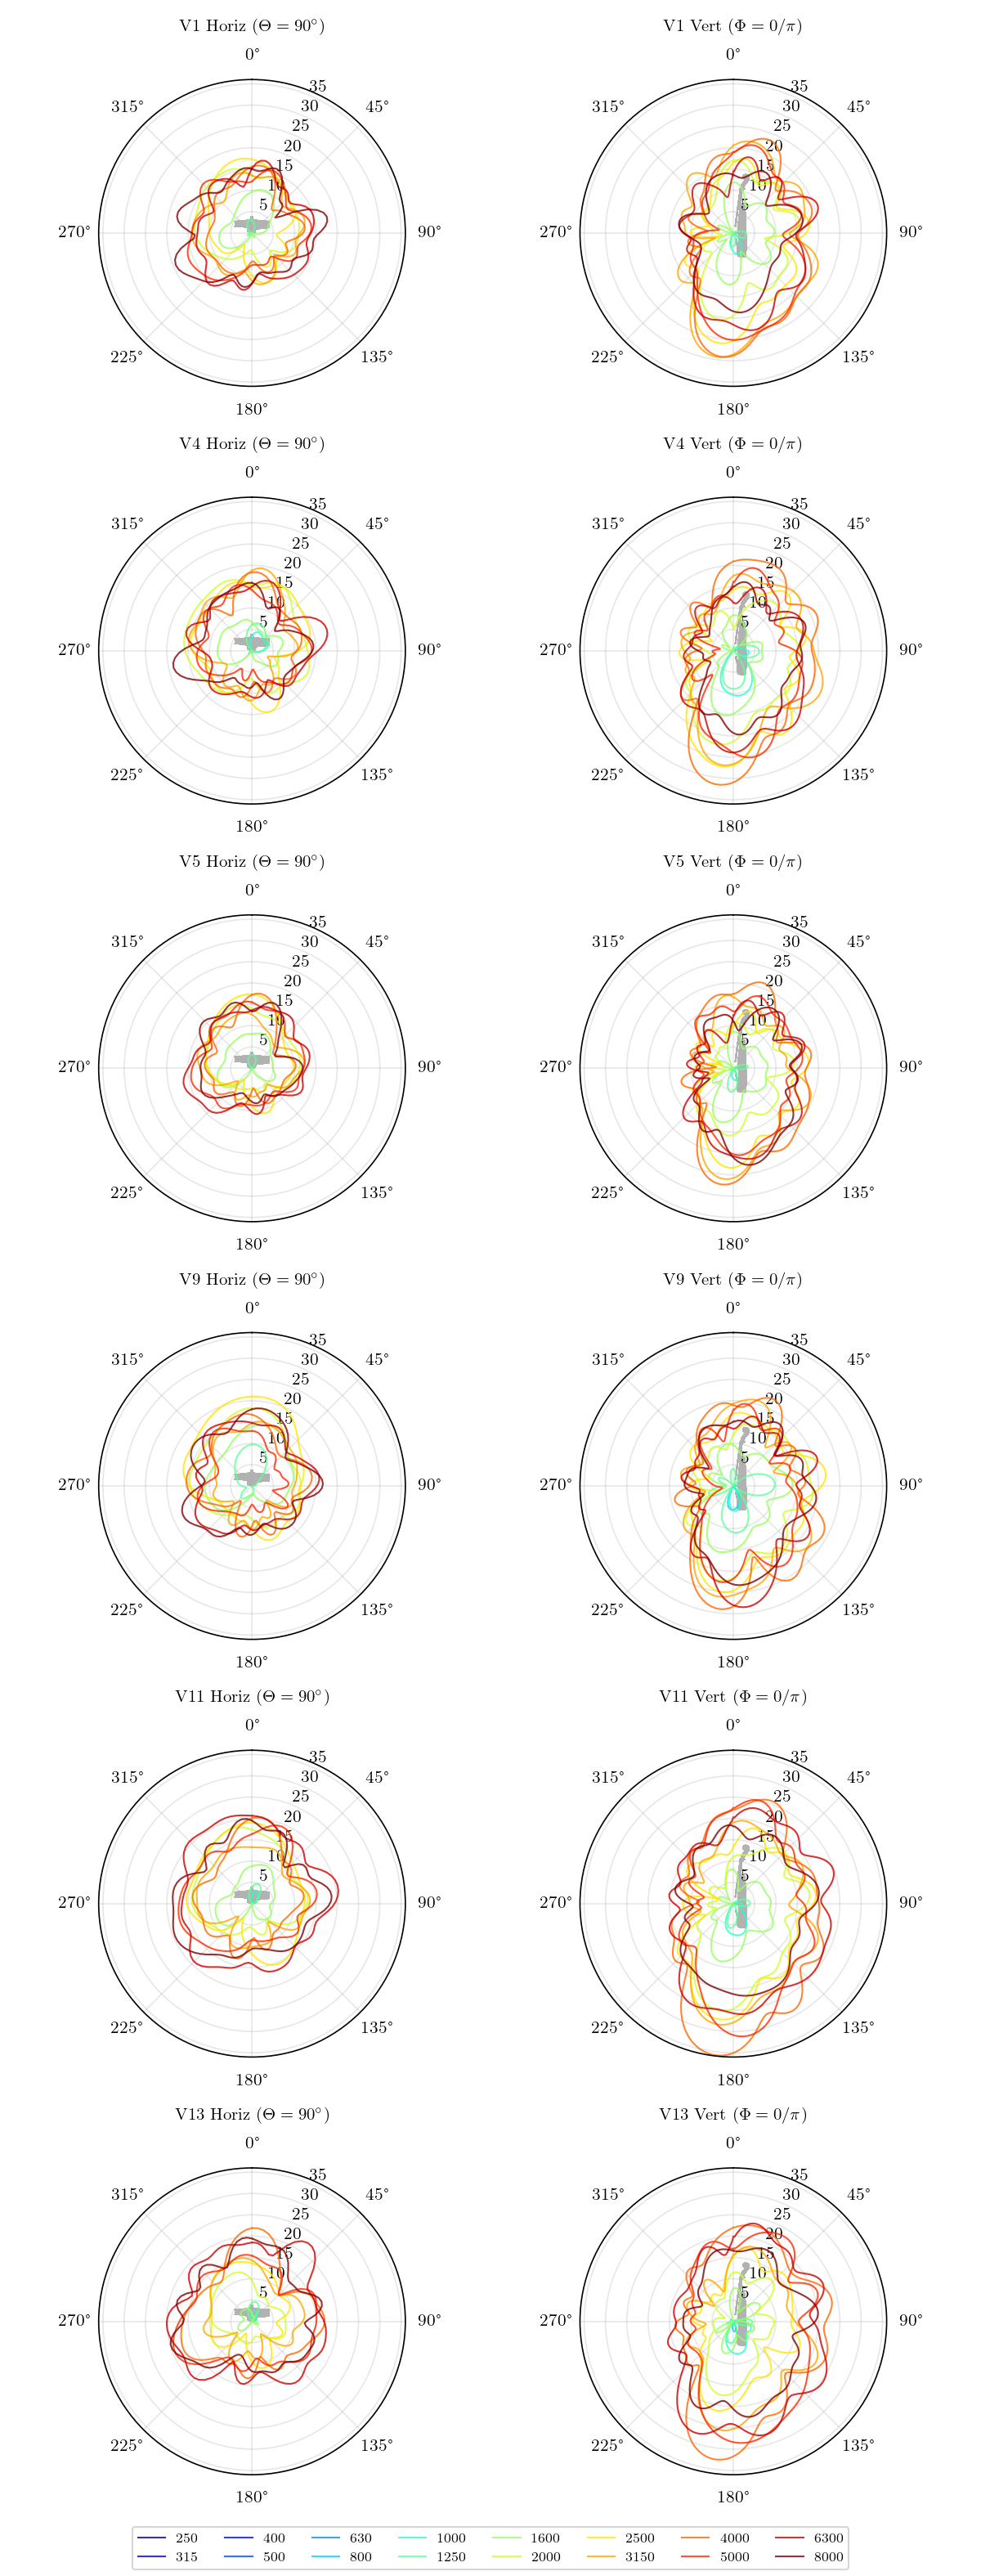

In [15]:
# Polar plots of Diag per 1/3 Octave Band
# Row 1: Horizontal Plane (Theta = 90 deg)
# Row 2: Vertical Plane (Combined Phi=0 and Phi=pi)

# 1. Define 1/3 Octave Bands
center_freqs_3rd = [
    250, 315, 400, 500, 630, 800, 1000, 1250, 1600, 2000, 
    2500, 3150, 4000, 5000, 6300, 8000
] # Hz

band_indices = []
# Factor for 1/3 octave: 2^(1/6)
bw_factor = 2**(1.0/6.0)

for fc in center_freqs_3rd:
    fmin = fc / bw_factor
    fmax = fc * bw_factor
    indices = np.where((f >= fmin) & (f <= fmax))[0]
    if len(indices) > 0:
        band_indices.append((fc, indices))

# 2. Calculate Linear Diag for all Bands first
NbBands_3rd = len(band_indices)
Diag_Band_3rd = np.zeros((NbViol, NbDirs, NbBands_3rd))

for i, (fc, idxs) in enumerate(band_indices):
    D_slice = Diag[:, :, :][:, :, idxs]
    # Sum of energy (squares)
    Diag_Band_3rd[:, :, i] = np.sqrt(np.sum(np.abs(D_slice)**2, axis=2))

RefVal = np.max(Diag_Band_3rd)
print(f"Global Max Linear Amplitude (1/3 Octave): {RefVal:.4e}")

# Convert to dB [0, DynRange]
Diag_Band_3rd_dB = 20 * np.log10(Diag_Band_3rd / RefVal + 1e-12)
Diag_Band_3rd_dB = np.maximum(Diag_Band_3rd_dB, -Dyn) + Dyn

# 3. Prepare Indices for planes

# Plane Theta = 90 (Horizontal/Equatorial) -> Function of Phi
target_theta = np.pi/2
closest_theta = theta_values[np.argmin(np.abs(theta_values - target_theta))]
indices_th90 = np.where(np.isclose(theta_values, closest_theta))[0]
sort_th90 = np.argsort(angles_look[indices_th90, 1])
indices_th90 = indices_th90[sort_th90]
angles_ph_th90 = angles_look[indices_th90, 1] 

# Plane Phi = 0 (Vertical/Meridional Front)
target_phi = 0
closest_phi = phi_values[np.argmin(np.abs(phi_values - target_phi))]
indices_ph0 = np.where(np.isclose(phi_values, closest_phi))[0]
sort_ph0 = np.argsort(angles_look[indices_ph0, 0])
indices_ph0 = indices_ph0[sort_ph0]
angles_th_ph0 = angles_look[indices_ph0, 0] # 0 to pi

# Plane Phi = pi (Vertical/Meridional Back)
dist_pi = np.minimum(np.abs(phi_values - np.pi), np.abs(phi_values + np.pi))
indices_ph180 = np.where(np.isclose(dist_pi, np.min(dist_pi)))[0]
sort_ph180 = np.argsort(angles_look[indices_ph180, 0])
indices_ph180 = indices_ph180[sort_ph180]
angles_th_ph180 = angles_look[indices_ph180, 0] # 0 to pi usually

# 4. Create Figure
fig, axes = plt.subplots(NbViol,2, figsize=(8, NbViol*3.5), subplot_kw={'projection': 'polar'})

colors = plt.cm.jet(np.linspace(0, 1, len(band_indices)))

for v in range(NbViol):
    # --- Row 0: Horizontal Plane (Theta=90) ---
    ax_h = axes[v, 0]
    ax_h.set_title(f'V{NumViolon[v]} Horiz ($\Theta=90^\circ$)', fontsize=10, pad=10)
    
    for i, (fc, idxs) in enumerate(band_indices):
        # Extract pre-calculated dB values
        Mag_dB_plane = Diag_Band_3rd_dB[v, indices_th90, i]

        # Close the loop
        Mag_plot = np.append(Mag_dB_plane, Mag_dB_plane[0])
        Ang_plot = np.append(angles_ph_th90, angles_ph_th90[0] + 2*np.pi) 
        
        ax_h.plot(Ang_plot, Mag_plot, color=colors[i], linewidth=1.0, alpha=0.8, label=f'{int(fc)}' if v==0 else "")

    ax_h.set_theta_zero_location("N")
    ax_h.set_theta_direction(-1)
    ax_h.set_ylim(0, Dyn)
    ax_h.set_rticks(np.arange(5, Dyn+1, 5))
    ax_h.grid(True, alpha=0.3)

    scale_val = 1.0
    if 'vertices' in locals() and 'faces' in locals():
        r_xy = np.hypot(vertices[:,0], vertices[:,1])
        scale_val = 5.0 / (np.max(r_xy) + 1e-12)
        r_xy = r_xy * scale_val
        th_xy = np.arctan2(vertices[:,1], vertices[:,0])
        ax_h.triplot(th_xy, r_xy, triangles=faces, color='k', alpha=0.3, linewidth=0.2)

    # --- Row 1: Vertical Plane (Phi=0 and Phi=pi) ---
    ax_v = axes[v, 1]
    ax_v.set_title(f'V{NumViolon[v]} Vert ($\Phi=0/\pi$)', fontsize=10, pad=10)
    
    for i, (fc, idxs) in enumerate(band_indices):
        # Extract pre-calculated dB values
        Mag_dB_0 = Diag_Band_3rd_dB[v, indices_ph0, i]
        Mag_dB_180 = Diag_Band_3rd_dB[v, indices_ph180, i]
        
        # Combine
        Mag_full = np.concatenate([Mag_dB_0, Mag_dB_180[::-1]])
        Ang_full = np.concatenate([angles_th_ph0, 2*np.pi - angles_th_ph180[::-1]])
        
        # Close loop
        Mag_full = np.append(Mag_full, Mag_full[0])
        Ang_full = np.append(Ang_full, 2*np.pi)
        
        ax_v.plot(Ang_full, Mag_full, color=colors[i], linewidth=1.0, alpha=0.8, label=f'{int(fc)}' if v==0 else "")

    ax_v.set_theta_zero_location("N")
    ax_v.set_theta_direction(-1)
    ax_v.set_ylim(0, Dyn)
    ax_v.set_rticks(np.arange(5, Dyn+1, 5))
    ax_v.grid(True, alpha=0.3)

    if 'vertices' in locals() and 'faces' in locals():
        r_xz = np.hypot(vertices[:,0], vertices[:,2])
        r_xz = r_xz * scale_val 
        th_xz = np.arctan2(vertices[:,0], vertices[:,2])
        th_xz = np.where(th_xz < 0, th_xz + 2*np.pi, th_xz)
        ax_v.triplot(th_xz, r_xz, triangles=faces, color='k', alpha=0.3, linewidth=0.2)

# Global Legend
handles, labels = axes[0, 0].get_legend_handles_labels()
# Use more columns for legend as there are many bands
# Place legend at bottom, leaving space with tight_layout rect
fig.legend(handles, labels, loc='lower center', ncol=8, bbox_to_anchor=(0.5, 0.0), fontsize=8, borderaxespad=0.5)

# Adjust layout to make room for legend at bottom
plt.tight_layout(rect=[0, 0.02, 1, 1])
plt.show()

Global Max Octave (Linear): 2.5238e+04


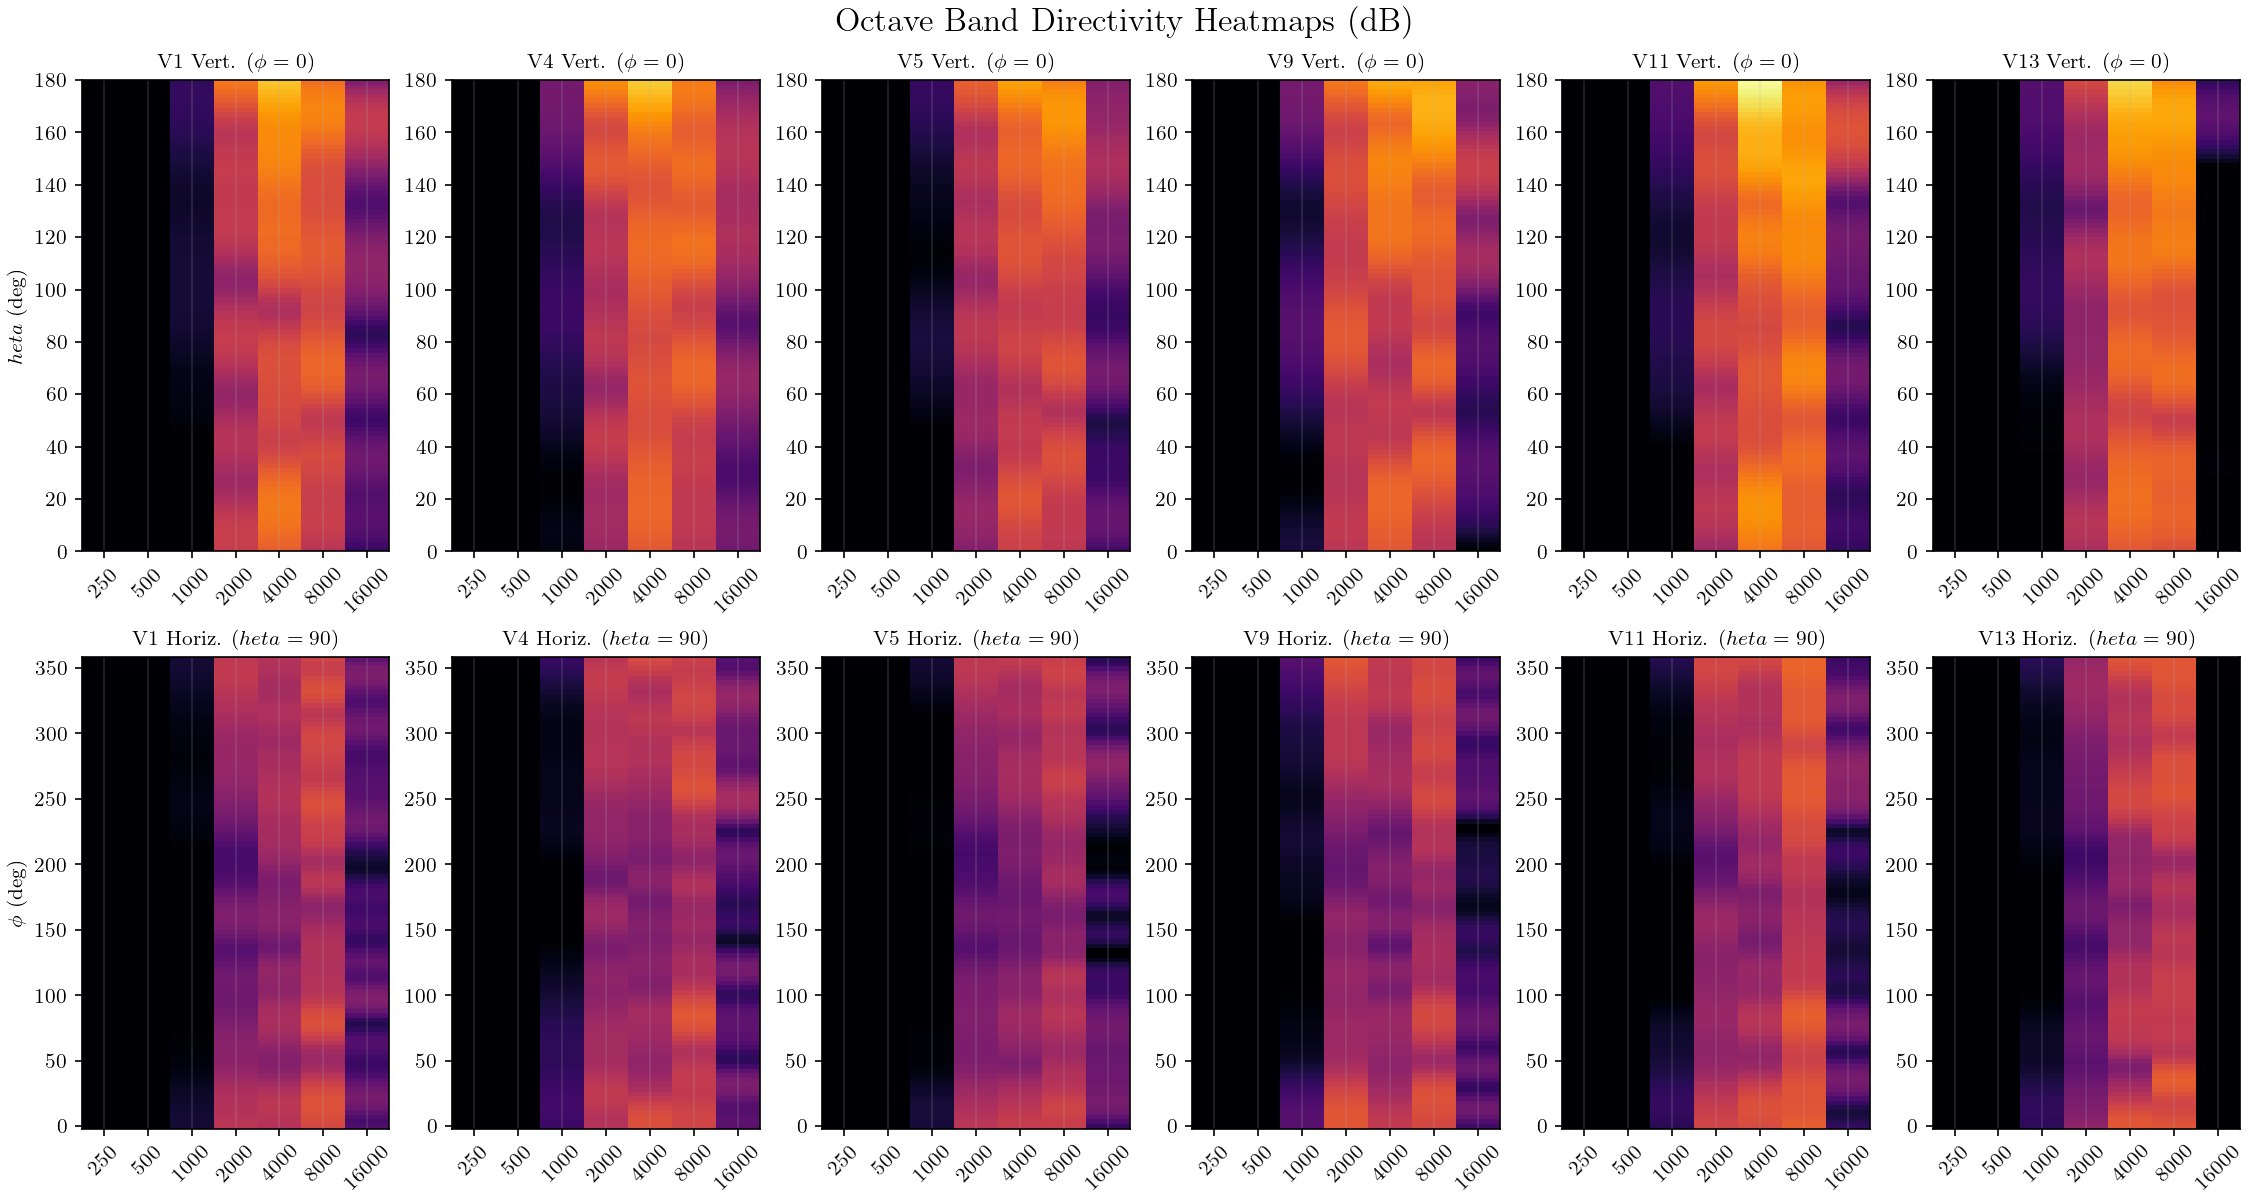

In [16]:
# --- Band Processing Helper ---
def compute_band_energy(Diag, f, center_freqs, bandwidth_factor=1):
    """
    Aggregates Diag matrix into frequency bands using sum of energy.
    bandwidth_factor: 1 for Octave, 3 for 1/3 Octave.
    Returns: Diag_Band (NbViol, NbDirs, NbBands)
    """
    NbViol, NbDirs, Nbf = Diag.shape
    NbBands = len(center_freqs)
    Diag_Band = np.zeros((NbViol, NbDirs, NbBands))
    
    # Factor for band limits: f_center * 2^( +/- 1 / (2*B) )
    factor = 2**(1.0 / (2.0 * bandwidth_factor))
    
    for i, fc in enumerate(center_freqs):
        fmin = fc / factor
        fmax = fc * factor
        indices = np.where((f >= fmin) & (f <= fmax))[0]
        
        if len(indices) > 0:
            # Sum of Energy: sqrt( sum( |D|^2 ) )
            # Axis 2 is frequency
            D_subset = Diag[:, :, indices]
            E_sum = np.sum(np.abs(D_subset)**2, axis=2) # Changed mean to sum
            Diag_Band[:, :, i] = np.sqrt(E_sum)
        else:
            Diag_Band[:, :, i] = 1e-16 # Avoid log(0)
             
    return Diag_Band

# --- 1. Octave Bands Heatmaps ---
center_freqs_oct = [250, 500, 1000, 2000, 4000, 8000, 16000]
Diag_Oct = compute_band_energy(Diag, f, center_freqs_oct, bandwidth_factor=1)

# Normalize dB
GlobalMax_Oct = np.max(Diag_Oct)
print(f"Global Max Octave (Linear): {GlobalMax_Oct:.4e}")

Diag_Oct_dB = 20 * np.log10(Diag_Oct / GlobalMax_Oct + 1e-16)

# Plot
fig, axes = plt.subplots(2, NbViol, figsize=(NbViol * 2.5, 8), constrained_layout=True)
fig.suptitle("Octave Band Directivity Heatmaps (dB)", fontsize=16)

# Row 0: Vertical Plane (Theta, Phi=0)
# Uses phi0_indices, thetas_deg from previous cells
for v in range(NbViol):
    ax = axes[0, v]
    Data = Diag_Oct_dB[v, phi0_indices, :] # (NbAng, NbBands)
    
    # Using shading='nearest' to avoid dimension mismatch with coordinates
    pcm = ax.pcolormesh(np.arange(len(center_freqs_oct)), thetas_deg, Data, 
                        cmap='inferno', vmin=-Dyn, vmax=0, shading='nearest')
    
    ax.set_title(f'V{NumViolon[v]} Vert. ($\phi=0$)')
    ax.set_xticks(np.arange(len(center_freqs_oct)))
    ax.set_xticklabels(center_freqs_oct, rotation=45)
    if v == 0: ax.set_ylabel(f'$\theta$ (deg)')
    ax.grid(True, alpha=0.2, axis='x')

# Row 1: Horizontal Plane (Phi, Theta=90)
# Uses theta0_indices, phis_deg from previous cells
for v in range(NbViol):
    ax = axes[1, v]
    Data = Diag_Oct_dB[v, theta0_indices, :]
    
    pcm = ax.pcolormesh(np.arange(len(center_freqs_oct)), phis_deg, Data, 
                        cmap='inferno', vmin=-Dyn, vmax=0, shading='nearest')
    
    ax.set_title(f'V{NumViolon[v]} Horiz. ($\theta=90$)')
    ax.set_xticks(np.arange(len(center_freqs_oct)))
    ax.set_xticklabels(center_freqs_oct, rotation=45)
    if v == 0: ax.set_ylabel(f'$\phi$ (deg)')
    ax.grid(True, alpha=0.2, axis='x')

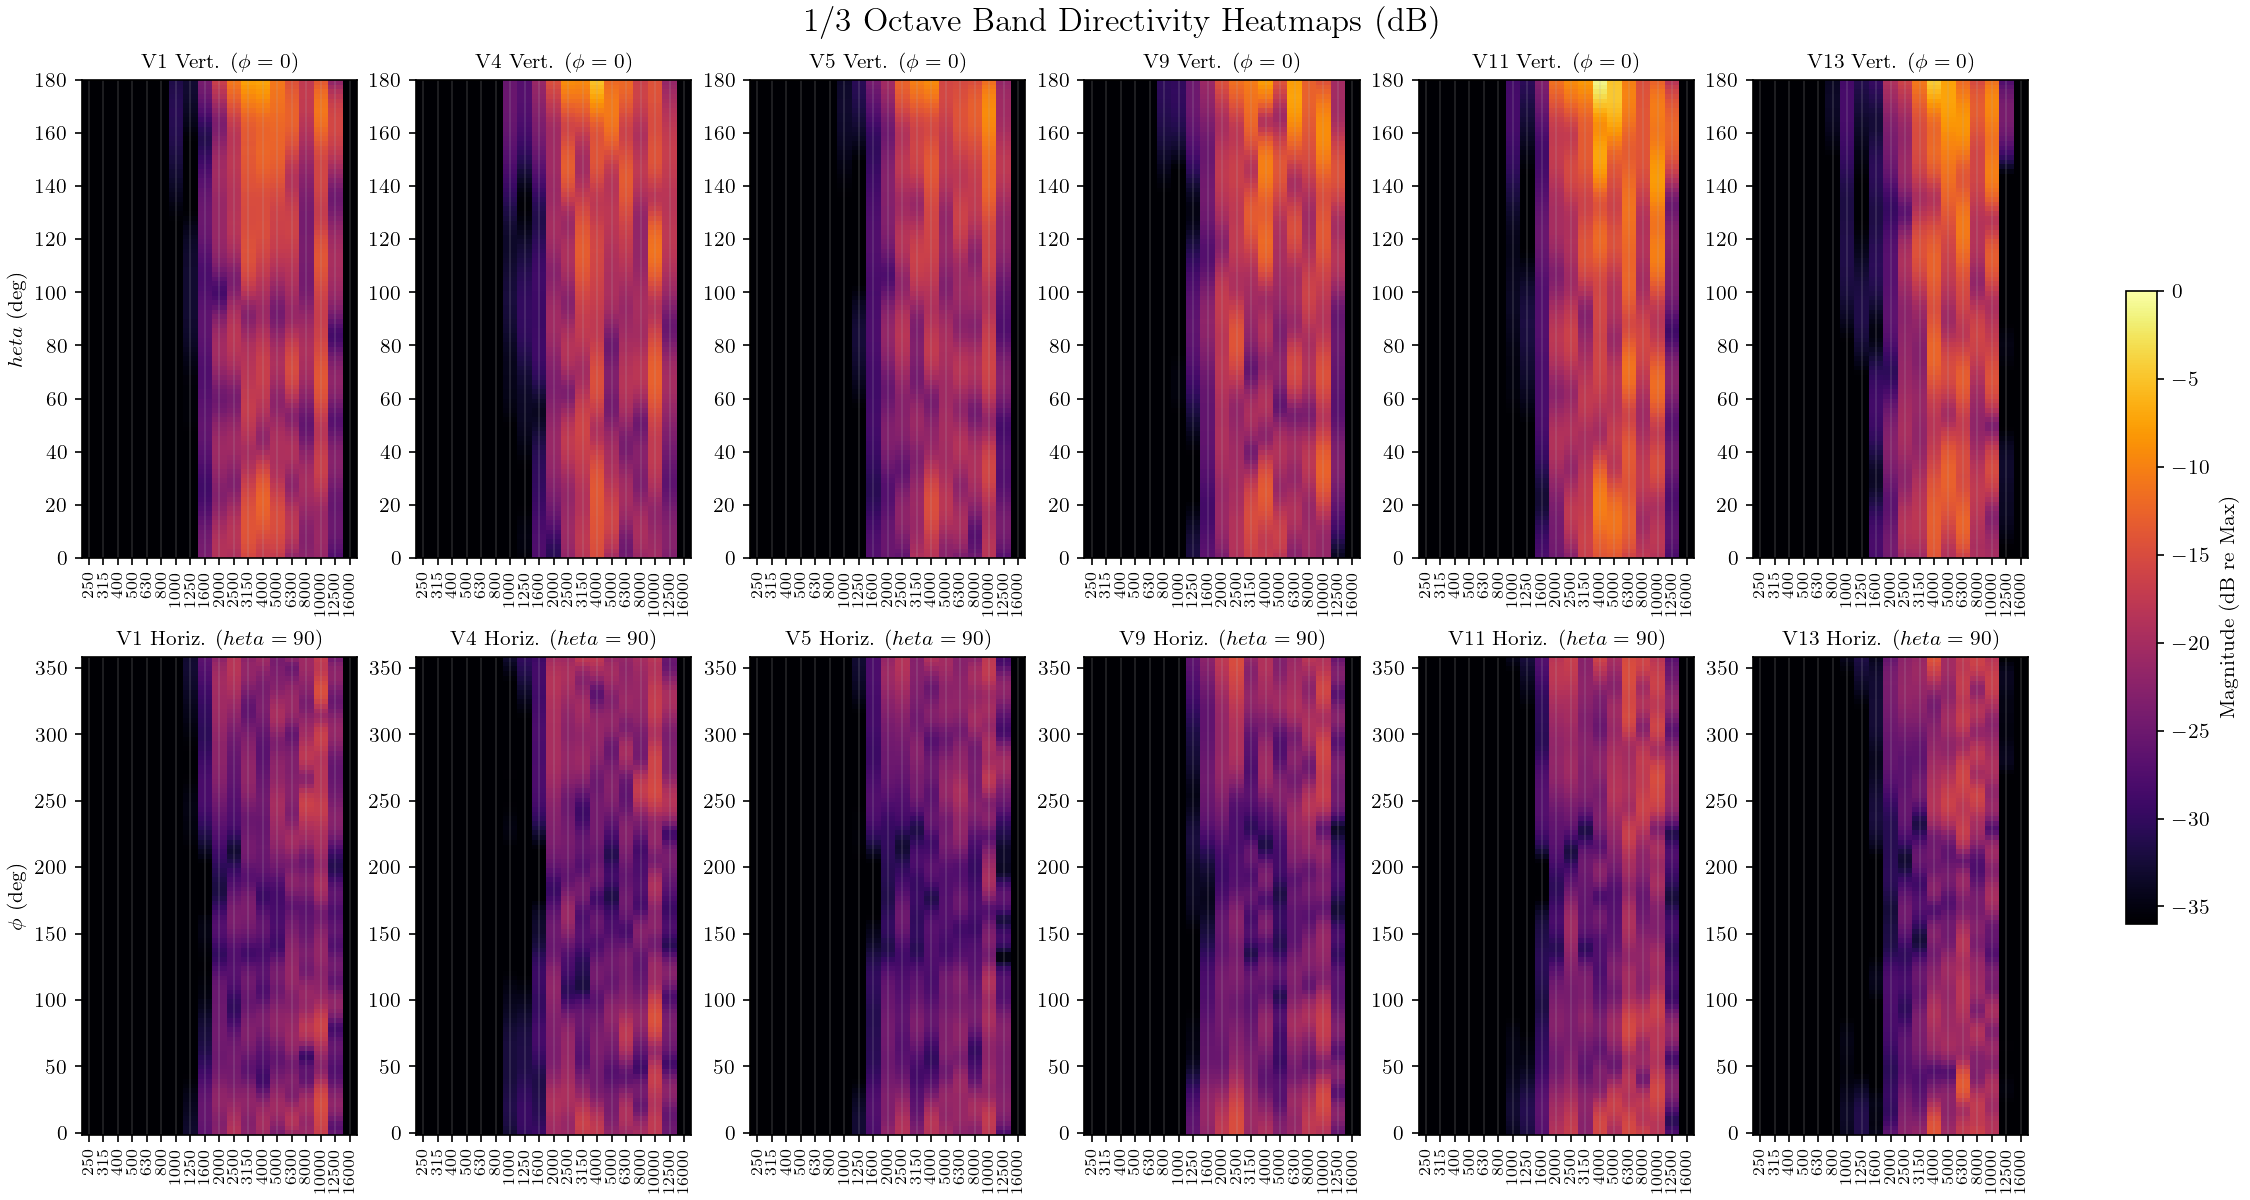

In [17]:
# --- 2. Third-Octave Bands Heatmaps ---
# ISO Preferred Frequencies
center_freqs_3rd = [
    250, 315, 400, 500, 630, 800, 1000, 1250, 1600, 2000, 
    2500, 3150, 4000, 5000, 6300, 8000, 10000, 12500, 16000
]

Diag_3rd = compute_band_energy(Diag, f, center_freqs_3rd, bandwidth_factor=3)

# Normalize dB
GlobalMax_3rd = np.max(Diag_3rd)
Diag_3rd_dB = 20 * np.log10(Diag_3rd / GlobalMax_3rd + 1e-16)

# Plot
fig, axes = plt.subplots(2, NbViol, figsize=(NbViol * 2.5, 8), constrained_layout=True)
fig.suptitle("1/3 Octave Band Directivity Heatmaps (dB)", fontsize=16)

# Row 0: Vertical Plane
for v in range(NbViol):
    ax = axes[0, v]
    Data = Diag_3rd_dB[v, phi0_indices, :] 
    
    pcm = ax.pcolormesh(np.arange(len(center_freqs_3rd)), thetas_deg, Data, 
                        cmap='inferno', vmin=-Dyn, vmax=0, shading='nearest')
    
    ax.set_title(f'V{NumViolon[v]} Vert. ($\phi=0$)')
    ax.set_xticks(np.arange(len(center_freqs_3rd)))
    ax.set_xticklabels(center_freqs_3rd, rotation=90, fontsize=8)
    if v == 0: ax.set_ylabel(f'$\theta$ (deg)')
    ax.grid(True, alpha=0.2, axis='x')

# Row 1: Horizontal Plane
for v in range(NbViol):
    ax = axes[1, v]
    Data = Diag_3rd_dB[v, theta0_indices, :]
    
    pcm = ax.pcolormesh(np.arange(len(center_freqs_3rd)), phis_deg, Data, 
                        cmap='inferno', vmin=-Dyn, vmax=0, shading='nearest')
    
    ax.set_title(f'V{NumViolon[v]} Horiz. ($\theta=90$)')
    ax.set_xticks(np.arange(len(center_freqs_3rd)))
    ax.set_xticklabels(center_freqs_3rd, rotation=90, fontsize=8)
    if v == 0: ax.set_ylabel(f'$\phi$ (deg)')
    ax.grid(True, alpha=0.2, axis='x')

cb = fig.colorbar(pcm, ax=axes[:,:], location='right', shrink=0.6)
cb.set_label('Magnitude (dB re Max)')
plt.show()

In [ ]:
import scipy.spatial
import json
from IPython.display import HTML

# Ensure data is available
if 'Diag' not in locals() or 'vertices' not in locals():
    print("Error: Diag or vertices not defined. Please run previous cells first (especially computation of Diag).")
else:
    # --- Prepare Geometry ---
    # 1. Violin Mesh
    v_verts = vertices.tolist()
    # faces might be trimesh object or array
    v_faces = faces.tolist() if isinstance(faces, np.ndarray) else faces

    # 2. Sphere Mesh (Directivity) from angles_look
    # angles_look: (N, 2) -> Theta, Phi. Assume standard spherical coords (Theta from Z, Phi from X)
    # R = 1 meter
    theta = angles_look[:, 0]
    phi = angles_look[:, 1]
    
    # Convert to Cartesian (Z-up)
    sx = np.sin(theta) * np.cos(phi)
    sy = np.sin(theta) * np.sin(phi)
    sz = np.cos(theta)
    s_points = np.stack([sx, sy, sz], axis=1)
    
    # Compute Convex Hull to get triangulation for these points
    hull = scipy.spatial.ConvexHull(s_points)
    s_faces = hull.simplices.tolist()
    s_verts = s_points.flatten().tolist() # [x0,y0,z0, x1,y1,z1, ...]

    # --- Prepare Data ---
    # Diag: (NbViol, NbDirs, Nbf)
    # We strip Phase, take Magnitude in dB.
    # To reduce data size for the browser, we can decimate frequency if needed.
    
    step_f = 1
    if len(f) > 500:
        step_f = int(len(f) / 500)
    
    f_sub = f[::step_f]
    Diag_sub = Diag[:, :, ::step_f]
    
    # Compute dB
    Mag = np.abs(Diag_sub)
    # Avoid log(0)
    Mag_dB = 20 * np.log10(Mag + 1e-12)
    
    # Transpose for JS: [Violin][Freq][Dir] -> easier to access frame data
    Mag_dB_T = Mag_dB.transpose(0, 2, 1)
    
    # Round to 2 decimals to save JSON space
    diag_data = np.round(Mag_dB_T, 2).tolist()
    freqs_list = np.round(f_sub, 1).tolist()
    
    # --- Generate HTML/JS ---
    html_template = f"""
    <!DOCTYPE html>
    <html>
    <head>
        <meta charset="utf-8">
        <title>Violin Directivity</title>
        <style>
            #viz-container {{ width: 100%; height: 600px; position: relative; background: #222; overflow: hidden; }}
            #viz-info {{
                position: absolute; top: 10px; width: 100%; text-align: center;
                color: #eee; font-family: monospace; font-size: 18px; pointer-events: none;
                text-shadow: 1px 1px 2px #000;
            }}
            #viz-gui {{ position: absolute; top: 10px; right: 10px; }}
        </style>
        <!-- Load Three.js and OrbitControls from CDN -->
        <script src="https://cdnjs.cloudflare.com/ajax/libs/three.js/r128/three.min.js"></script>
        <script src="https://cdnjs.cloudflare.com/ajax/libs/dat-gui/0.7.7/dat.gui.min.js"></script>
        <script src="https://cdn.jsdelivr.net/npm/three@0.128.0/examples/js/controls/OrbitControls.js"></script>
    </head>
    <body>
        <div id="viz-container">
            <div id="viz-info">Freq: <span id="lbl-freq"></span> Hz</div>
        </div>
        <script>
        (function() {{
            // Encapsulate to avoid global namespace pollution in Notebook
            const container = document.getElementById('viz-container');
            
            // --- DATA ---
            const vVerts = {json.dumps(v_verts)};
            const vFaces = {json.dumps(v_faces)};
            const sVerts = {json.dumps(s_verts)}; // Flattened
            const sFaces = {json.dumps(s_faces)};
            const dataDB = {json.dumps(diag_data)}; // [Violin][Freq][Dir]
            const freqs = {json.dumps(freqs_list)};
            const nbViol = {len(NumViolon)};
            
            // --- CONFIG ---
            const params = {{
                violin: 0,
                minLevel: 50,
                maxLevel: 100,
                speed: 1,
                freqIdx: 0,
                play: true,
                opacity: 0.6
            }};
            
            // Auto-detect range from first frame
            if (dataDB[0] && dataDB[0][0]) {{
                const firstFrame = dataDB[0][0];
                let max = -9999;
                for(let v of firstFrame) if(v>max) max=v;
                params.maxLevel = Math.ceil(max);
                params.minLevel = params.maxLevel - 30;
            }}

            // --- THREEJS SETUP ---
            const scene = new THREE.Scene();
            scene.background = new THREE.Color(0x222222);
            
            // Camera Z-up
            const camera = new THREE.PerspectiveCamera(50, container.clientWidth / container.clientHeight, 0.1, 100);
            camera.position.set(1.5, 1.5, 1.5);
            camera.up.set(0, 0, 1);
            
            const renderer = new THREE.WebGLRenderer({{ antialias: true, alpha: true }});
            renderer.setSize(container.clientWidth, container.clientHeight);
            container.appendChild(renderer.domElement);
            
            const controls = new THREE.OrbitControls(camera, renderer.domElement);
            controls.enableDamping = true;
            
            // Lights
            scene.add(new THREE.AmbientLight(0x404040));
            const dl = new THREE.DirectionalLight(0xffffff, 0.8);
            dl.position.set(2, 2, 5);
            scene.add(dl);
            const dl2 = new THREE.DirectionalLight(0xffffff, 0.5);
            dl2.position.set(-2, -5, 0);
            scene.add(dl2);
            
            // Grid
            const grid = new THREE.GridHelper(5, 10);
            grid.rotation.x = Math.PI / 2; // Lie on XY plane if Z is up
            scene.add(grid);
            scene.add(new THREE.AxesHelper(1));

            // --- MESH GENERATION ---
            
            // 1. Violin (Brown, Wireframe or Phong)
            const geomV = new THREE.BufferGeometry();
            geomV.setAttribute('position', new THREE.Float32BufferAttribute(vVerts.flat(), 3));
            geomV.setIndex(vFaces.flat());
            geomV.computeVertexNormals();
            
            const matV = new THREE.MeshPhongMaterial({{ color: 0xcd853f, side: THREE.DoubleSide }});
            const meshV = new THREE.Mesh(geomV, matV);
            // Center if needed
            scene.add(meshV);
            
            // 2. Directivity Sphere (Vertex Colors)
            const geomS = new THREE.BufferGeometry();
            geomS.setAttribute('position', new THREE.Float32BufferAttribute(sVerts, 3));
            geomS.setIndex(sFaces.flat());
            
            const count = sVerts.length / 3;
            const colors = new Float32Array(count * 3);
            geomS.setAttribute('color', new THREE.BufferAttribute(colors, 3));
            
            const matS = new THREE.MeshBasicMaterial({{ vertexColors: true, side: THREE.DoubleSide, transparent: true, opacity: params.opacity }});
            const meshS = new THREE.Mesh(geomS, matS);
            scene.add(meshS);
            
            // --- GUI ---
            const gui = new dat.GUI({{ autoPlace: false }});
            container.appendChild(gui.domElement);
            Object.assign(gui.domElement.style, {{ position: 'absolute', top: '10px', right: '10px' }});
            
            gui.add(params, 'violin', 0, nbViol - 1, 1).name('Violin #');
            gui.add(params, 'minLevel', -100, 150).name('Min dB');
            gui.add(params, 'maxLevel', -100, 150).name('Max dB');
            gui.add(params, 'opacity', 0, 1).onChange(v => matS.opacity = v);
            gui.add(params, 'speed', 1, 10, 1).name('Speed');
            gui.add(params, 'play').name('Play Animation');
            const cFreq = gui.add(params, 'freqIdx', 0, freqs.length - 1, 1).name('Freq Index').listen();
            
            // --- ANIMATION LOOP ---
            const lbl = document.getElementById('lbl-freq');
            
            function updateColors() {{
                // Handle float index from animation
                const v = Math.floor(params.violin);
                let f = Math.floor(params.freqIdx);
                if (f >= freqs.length) f = freqs.length - 1;
                
                const vals = dataDB[v][f];
                if (!vals) return;
                
                const attrColor = meshS.geometry.attributes.color;
                const min = params.minLevel;
                const max = params.maxLevel;
                const range = max - min || 1;
                
                for (let i = 0; i < vals.length; i++) {{
                    const db = vals[i];
                    let n = (db - min) / range;
                    n = Math.max(0, Math.min(1, n));
                    
                    // Heatmap (Blue-Cyan-Green-Yellow-Red)
                    const color = new THREE.Color();
                    color.setHSL((1.0 - n) * 0.66, 1.0, 0.5);
                    
                    attrColor.setXYZ(i, color.r, color.g, color.b);
                }}
                attrColor.needsUpdate = true;
                lbl.innerText = freqs[f].toFixed(1);
            }}

            function animate() {{
                requestAnimationFrame(animate);
                
                if (params.play) {{
                    params.freqIdx += (0.2 * params.speed); 
                    if (params.freqIdx >= freqs.length) params.freqIdx = 0;
                }}
                
                // Update every frame for smoothness (interpolating indices if we wanted, but here nearest)
                updateColors();
                controls.update();
                renderer.render(scene, camera);
            }}
            
            animate();
            
            const ro = new ResizeObserver(() => {{
                camera.aspect = container.clientWidth / container.clientHeight;
                camera.updateProjectionMatrix();
                renderer.setSize(container.clientWidth, container.clientHeight);
            }});
            ro.observe(container);
            
        }})();
        </script>
    </body>
    </html>
    """
    display(HTML(html_template))
